In [20]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import tiktoken
import matplotlib.pyplot as plt

import sys
import os
project_root = os.path.abspath('..')

if project_root not in sys.path:
    sys.path.append(project_root)
from model import GPTModel
from utils import create_dataloader_v1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Wczytanie i konfiguracja modelu

In [21]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, #słownik
    "context_length": 256, #kontekst
    "emb_dim": 768, #osadzenia
    "n_heads": 12, #głowice uwagi
    "n_layers": 12, #warstwy
    "drop_rate": 0.1, #porzucenie
    "qkv_bias": False
}

In [22]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [23]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())


In [24]:
from utils import generate_text_simple

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

In [25]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Tekst wynikowy:\n", token_ids_to_text(token_ids, tokenizer))

Tekst wynikowy:
 Every effort moves you rentingetic minion mobilized Macicone warrantyuler anim supra


## Oblicznanie straty

### Ładowaie tekstu

In [26]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read() 

In [27]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Liczba znaków:", total_characters)
print("Liczba tokenów:", total_tokens)

Liczba znaków: 20479
Liczba tokenów: 5145


### Podział danych

In [28]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [29]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_lenght=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_lenght=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [30]:
print("Szkoleniowy mechanizm ładujący:")
for x, y in train_loader:
    print(x.shape, y.shape)

Szkoleniowy mechanizm ładujący:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


In [31]:
print("\nWalidacyjny mechanizm ładujący:")
for x, y in val_loader:
    print(x.shape, y.shape)


Walidacyjny mechanizm ładujący:
torch.Size([2, 256]) torch.Size([2, 256])


In [32]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss

In [33]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [34]:
print(torch.backends.mps.is_available())

False


In [35]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [36]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
    print("Strata zbioru szkoleniowego: ", train_loss)
    print("Strata zbioru walidacyjnego:", val_loss)

Strata zbioru szkoleniowego:  10.987067222595215
Strata zbioru walidacyjnego: 10.981829643249512


## Prosta pętla szkoleniowa

In [48]:
def train_model_simple(model, train_loader, val_loader, optimizer,
                       device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [],[],[]
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )

            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoka {epoch+1} (krok {global_step:06d}): "
                      f"Strata zbioru szkoleniowego {train_loss:.3f}, "
                      f"Strata zbioru walidacyjnego {val_loss:.3f}")
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

In [49]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )

        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        model.train()
        return train_loss, val_loss

In [50]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [51]:
torch.manual_seed(123)
model=GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay=0.1)
num_epochs=10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Epoka 1 (krok 000000): Strata zbioru szkoleniowego 9.762, Strata zbioru walidacyjnego 9.900
Epoka 1 (krok 000005): Strata zbioru szkoleniowego 8.111, Strata zbioru walidacyjnego 8.334
Every effort moves you,,,,,,,,,,,,,,.                                   
Epoka 2 (krok 000010): Strata zbioru szkoleniowego 6.564, Strata zbioru walidacyjnego 7.044
Epoka 2 (krok 000015): Strata zbioru szkoleniowego 6.073, Strata zbioru walidacyjnego 6.606
Every effort moves you, and, and. "". "".                                     
Epoka 3 (krok 000020): Strata zbioru szkoleniowego 5.619, Strata zbioru walidacyjnego 6.467
Epoka 3 (krok 000025): Strata zbioru szkoleniowego 5.425, Strata zbioru walidacyjnego 6.394
Every effort moves you, and I had been theisburn, and, and I had been, and, and I had been the                           
Epoka 4 (krok 000030): Strata zbioru szkoleniowego 5.230, Strata zbioru walidacyjnego 6.468
Epoka 4 (krok 000035): Strata zbioru szkoleniowego 4.945, Strata zbioru walidacyjn

In [52]:
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Strata zbioru szkoleniowego")
    ax1.plot(
    epochs_seen, val_losses, linestyle="-.", label="Strata zbioru walidacyjnego"
    )
    ax1.set_xlabel("Epoki")
    ax1.set_ylabel("Strata")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Zaobserwowane tokeny")
    fig.tight_layout()
    plt.show()

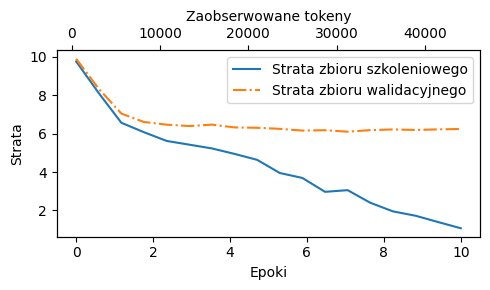

In [53]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Strategie dekodowania

In [54]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [55]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Wynikowy tekst:\n", token_ids_to_text(token_ids, tokenizer))

Wynikowy tekst:
 Every effort moves you know," was not that my hostess was "interesting": on that point I could have given Miss Croft the fact,


#### Skalowanie temepraturą

In [57]:
vocab = {
"closer": 0,
"every": 1,
"effort": 2,
"forward": 3,
"inches": 4,
"moves": 5,
"pizza": 6,
"toward": 7,
"you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [58]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [59]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

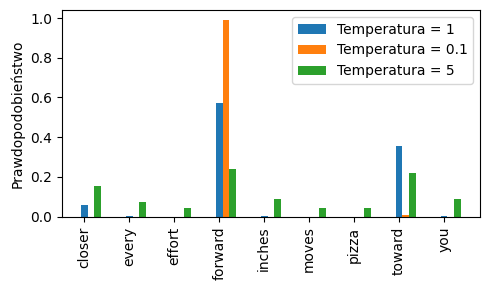

In [61]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f"Temperatura = {T}")
ax.set_ylabel("Prawdopodobieństwo")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

#### Próbkowanie top-k

In [62]:
top_k=3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Najwyższe wartości logitów:", top_logits)
print("Pozycje najwyższych wartości:", top_pos)

Najwyższe wartości logitów: tensor([6.7500, 6.2800, 4.5100])
Pozycje najwyższych wartości: tensor([3, 7, 0])


In [63]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [64]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])
